In [2]:
import torch
import numpy as np
from tqdm import tqdm

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
generated_store = torch.load('../logs/finetune/generated_molecules.pt')

In [4]:
generated_replay_online_store = torch.load('../logs/finetune-R-PRS-WithOnline/generated_molecules_98.pt')

In [5]:
generated_bs32_store = torch.load('../logs/finetune-bs-32/generated_molecules_687.pt')

In [6]:
generated_replay_store = torch.load('../logs/finetune-R-PRS/generated_molecules_160.pt')

In [7]:
torch.save(generated_replay_store, '../logs/finetune-R-PRS/generated_molecules_160.pt')

In [8]:
no_finetune_ds = torch.load('../misc/ranking_analysis/14gs_A_docking_scores_no_finetune.pt')

In [9]:
top_count = 100

In [11]:
top_100 = []

docking_scores = [ds.item() for ds in generated_store['docking_scores']]
for i in range(top_count, len(docking_scores), 100):
    subset = docking_scores[:i]
    subset.sort()
    top_100.append(np.mean(subset[:top_count]))    

In [12]:
import random
top_100_no_finetune = []

random.shuffle(no_finetune_ds)
for i in range(top_count, len(no_finetune_ds), 100):
    subset = no_finetune_ds[:i]
    subset.sort()
    top_100_no_finetune.append(np.mean(subset[:top_count]))

In [13]:
top_100_bs32 = []

bs32_docking_scores = [ds.item() for ds in generated_bs32_store['docking_scores']]

for i in range(top_count, len(bs32_docking_scores[:30000]), 100):
    subset = bs32_docking_scores[:i]
    subset.sort()
    top_100_bs32.append(np.mean(subset[:top_count]))

In [14]:
top_100_replay = []
replay_docking_scores = generated_replay_store['docking_scores'][:30000]
for i in range(top_count, len(replay_docking_scores), 100):
    subset = replay_docking_scores[:i]
    subset.sort()
    top_100_replay.append(np.mean(subset[:top_count]))

In [15]:
top_100_replay_online = []
replay_online_docking_scores = generated_replay_online_store['docking_scores'][:30000]
for i in range(top_count, len(replay_online_docking_scores), 100):
    subset = replay_online_docking_scores[:i]
    subset.sort()
    top_100_replay_online.append(np.mean(subset[:top_count]))

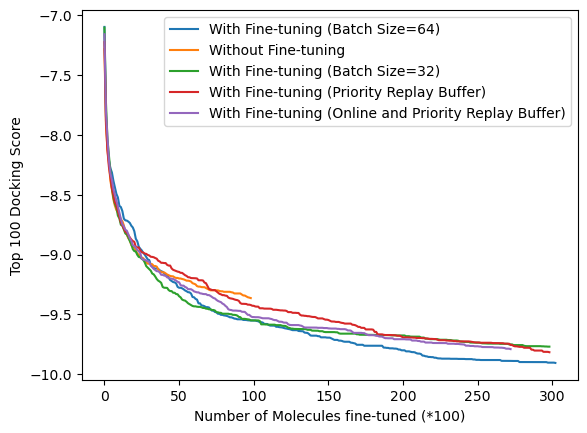

In [16]:
import matplotlib.pyplot as plt

plt.plot(top_100, label='With Fine-tuning (Batch Size=64)')
plt.plot(top_100_no_finetune, label='Without Fine-tuning')
plt.plot(top_100_bs32, label='With Fine-tuning (Batch Size=32)')
plt.plot(top_100_replay, label='With Fine-tuning (Priority Replay Buffer)')
plt.plot(top_100_replay_online, label='With Fine-tuning (Online and Priority Replay Buffer)')
plt.ylabel('Top 100 Docking Score')
plt.xlabel('Number of Molecules fine-tuned (*100)')
plt.legend()
plt.show()


In [48]:
from queue import PriorityQueue
q = PriorityQueue()

q.put((2, "Smith"))
q.put((1, "Jones"))
q.put((4, "Wilson"))

nxt = q.get()
print(nxt)

print(q.empty())
print(q.full())

q.put((3, "Collins"))
print(q.get())

while not q.empty():
    print(q.get())

print(q.empty())

(1, 'Jones')
False
False
(2, 'Smith')
(3, 'Collins')
(4, 'Wilson')
True
